<a href="https://colab.research.google.com/github/talking-bird/Skoltech/blob/main/Geometric%20Deep%20Learning/Metropolis_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from numba import njit
from tqdm import trange, tqdm
from numba.typed import List

import networkx as nx

## Initialization and supplementary functions

In [29]:
def get_graph(file: str):
    '''
    reads graph from file
    ''' 
    G = nx.Graph()
    with open(file) as f:
        n, N = f.readline().split(' ') # n edges, N nodes
        n, N = int(n), int(N)
        G.add_nodes_from(np.arange(1,N+1))
        for row in f:
            node1, node2 = row.split(' ')
            node1, node2 = int(node1), int(node2)
            G.add_edge(node1, node2)
        
        assert nx.number_of_nodes(G) == N,\
            f'graph has {nx.number_of_nodes(G)} nodes, expected to have {N} nodes'
        assert nx.number_of_edges(G) == n,\
            f'graph has {nx.number_of_edges(G)} edges, expected to have {n} edges'

    return G

In [30]:
def adj_matrix(G):
    '''
    creates adj and neigbors:
    adj: 2D adjacency matrix of a graph
    neighbors: list of lists of neighbors (indexes from 0 to N-1, where N is a number of nodes)
    '''
    adj = adj_matrix = nx.to_numpy_array(G)

    neighbors = List()
    for i in range(1, nx.number_of_nodes(G)+1):
        neighbors_ = List([neighbor-1 for neighbor in nx.neighbors(G, i)])
        # for numba to interpret the type of empty list
        if len(neighbors_) == 0:
            neighbors_ = List.empty_list(nb.int64)
        neighbors.append(neighbors_)
    return adj, neighbors

adjacency matrix
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]
neigbors
[[1, 2, 3], [0, 3, 2], [0, 3, 1], [0, 1, 2], []]


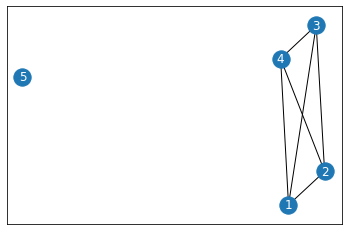

In [31]:
# example of the file with graph data:
with open('test.txt', 'w') as f:
    f.write('6 5\n')
    f.write('1 2\n')
    f.write('1 3\n')
    f.write('1 4\n')
    f.write('2 4\n')
    f.write('3 4\n')
    f.write('2 3\n')

G = get_graph('test.txt')

adj, neighbors = adj_matrix(G)
print('adjacency matrix')
print(adj)
print('neigbors')
print(neighbors)
nx.draw_networkx(G, with_labels=True, font_color='white')

In [32]:
def system_initialization(file: str):
    '''
    - Uses previously stated functions get_graph and adj_matrix to initialize 
    all needed information about graph
    - Initializes sensors positions
    ----------------------------------
    G: graph
    adj: adjacency matrix
    N_sensors: number of sensors
    sensors: ndarray of sensors' indexes 
    is_sensor: ndarray stating wether a node has a sensor or it's vacant
    '''
    G = get_graph(file)
    n = nx.number_of_edges(G)
    N_nodes = nx.number_of_nodes(G)

    adj, neighbors = adj_matrix(G)
    sensors = np.arange(0,N_sensors)
    
    # sensors initial distribution
    is_sensor = np.zeros(N_nodes, dtype=bool)
    is_sensor[:N_sensors] = 1

    return G, adj, neighbors, sensors, is_sensor

In [33]:

@njit
def one_sensor_energy(sensor_number, sensors, is_sensor, neighbors, adj, eps, sigma):
    '''
    calculates energy for 1 sensor
    '''
    E = 0
    node_number = sensors[sensor_number]
    # determine neighbors
    for i in range(len(neighbors[node_number])):
        neighbor = neighbors[node_number][i]
        # add energy for every neighbor
        if is_sensor[neighbor]:
            weight = adj[node_number, neighbor]
            E += 4*eps*((sigma/weight)**12-(sigma/weight)**6)
    return E

@njit
def total_energy(sensors, is_sensor, neighbors, adj, eps, sigma):
    '''
    calculates energy for all sensors ( total energy )
    '''
    E_tot = 0
    for i in range(N_sensors):
        E_tot += one_sensor_energy(i, sensors, is_sensor, neighbors, adj, eps, sigma)
    return E_tot/2

## Metropolis algorithm

In [34]:
@njit
def step(sensors, is_sensor, E_tot, Statistic, neighbors, adj, eps, sigma):
    '''
    one step of a Metropolis algorithm cycle:

    1. shifts one random sensor to the neigboring node
    2. calculates the difference in energy
    3. accepts\rejects new location of the sensor
    '''

    # choose the random sensor
    choice = np.random.choice
    old_sensor_number = choice(np.arange(N_sensors))
    old_node_number = sensors[old_sensor_number]

    # skip to the next step if there are no neighbors
    if len(neighbors[old_node_number]) == 0:
        # no neighbors
        Statistic[0] +=1 
        return sensors, is_sensor, E_tot, Statistic

    # choose the random neighboring node of the chosen one
    num_of_neighbors = len(neighbors[old_node_number])
    neighboring_loc = choice(np.arange(num_of_neighbors))
    new_node_number = neighbors[old_node_number][neighboring_loc]

    # skip to the next step if the chosen node is occupied
    if is_sensor[new_node_number]:
        Statistic[1] +=1
        return sensors, is_sensor, E_tot, Statistic

    #shift the sensor
    is_sensor[old_node_number] = 0
    is_sensor[new_node_number] = 1
    sensors_new = np.delete(sensors, old_sensor_number) 
    sensors_new = np.append(sensors_new, new_node_number)

    # calculate the difference in energy
    E_new = total_energy(sensors_new, is_sensor, neighbors, adj, eps, sigma)
    dE = E_new - E_tot
    # accept/reject
    dp = np.exp(-dE/T)
    if dp > np.random.random():
        # accept
        E_tot = E_new
        Statistic[2] +=1
        return sensors_new, is_sensor, E_tot, Statistic
    else:
        # reject
        #return the sensor back
        Statistic[3] +=1
        is_sensor[old_node_number] = 1
        is_sensor[new_node_number] = 0
        return sensors, is_sensor, E_tot, Statistic

In [35]:
@njit
def cycle(sensors, is_sensor, E_tot, neighbors, adj, steps, eps, sigma):
    '''
    cycle of metropolis algorithm's steps
    stores information about energy levels during the simulation
    '''
    Statistics = [0., # 'no_neighbors'
                  0., # 'occupied'
                  0., # 'accepted'
                  0.] # 'rejected'
    E_arr = []
    time_arr = []

    best_sensor_loc = sensors.copy()
    E_min = E_tot
    best_step = 0

    for i in np.arange(1,steps+1):
        sensors, is_sensor, E_tot, Statistics = step(sensors, is_sensor, E_tot, 
                                                        Statistics, neighbors, adj, eps, sigma)
        if E_tot < E_min:
            best_sensor_loc = sensors.copy()
            E_min = E_tot
            best_step = i

        if steps<10**4 or i%(steps//10**4) == 0:
            E_arr.append(E_tot)
            time_arr.append(i)
    for i in range(4):
        Statistics[i] /= steps
    return sensors, is_sensor, E_arr, E_tot, time_arr, Statistics,\
        best_sensor_loc, E_min, best_step

In [36]:
def simulation(eps, sigma, adj, neighbors, sensors, is_sensor, steps=10**5):
    '''
    does the simulation and returns numerical results
    '''
    E_tot = total_energy(sensors, is_sensor, neighbors, adj, eps, sigma)
    sensors, is_sensor, E_arr, E_tot, time_arr, Statistics, best_sensor_loc, E_min, best_step =\
        cycle(sensors, is_sensor, E_tot, neighbors, adj, steps, eps, sigma)

    # verification of right energy calculation
    E_fin = total_energy(sensors, is_sensor, neighbors, adj, eps, sigma)
    assert np.isclose(E_fin, E_tot), f'E_fin={E_fin}, E_tot={E_tot}'

    return sensors, is_sensor, E_arr, time_arr, Statistics, best_sensor_loc, E_min, best_step

In [37]:
def show_and_save_results(eps, sigma,E_arr, time_arr, Statistics, steps):
    '''
    visualizes the numerical data
    '''
    # plot graphs
    value = E_arr
    values_name = r'$E$'
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
    fig.suptitle(r"steps = {:<2.0e},$\varepsilon=${:2.2f}, $\sigma=${:2.3f}, success rate  = {:<1.3f}, rejection rate  = {:<1.3f}, node was occupied: {:<1.3f}, no neighbours:{:<1.2e}".format(
        steps, eps, sigma, Statistics[2],Statistics[3],Statistics[1],Statistics[0]), fontsize=20)
    ax.plot(time_arr, value)
    ax.set_ylabel(values_name,fontsize=16)
    ax.set_xlabel('steps',fontsize=16)
    plt.show()
    # save results

    # with open('steps_{:1.0e}.npy'.format(steps), 'wb') as f:
    #     np.save(f, sensors)
    #     np.save(f, is_sensor)
    #     np.save(f, E_arr)
    #     np.save(f, time_arr)
    #     np.save(f, np.array([steps, succ_rate]))

In [38]:
T = 1 # K
N_sensors = 2
sigma, eps = 1, 100
steps=10**3
file = 'test.txt'
G, adj, neighbors, sensors, is_sensor = system_initialization(file)
sensors, is_sensor, E_arr, time_arr, Statistics, best_sensor_loc, E_min, best_step =\
    simulation(eps, sigma, adj, neighbors, sensors, is_sensor, steps)

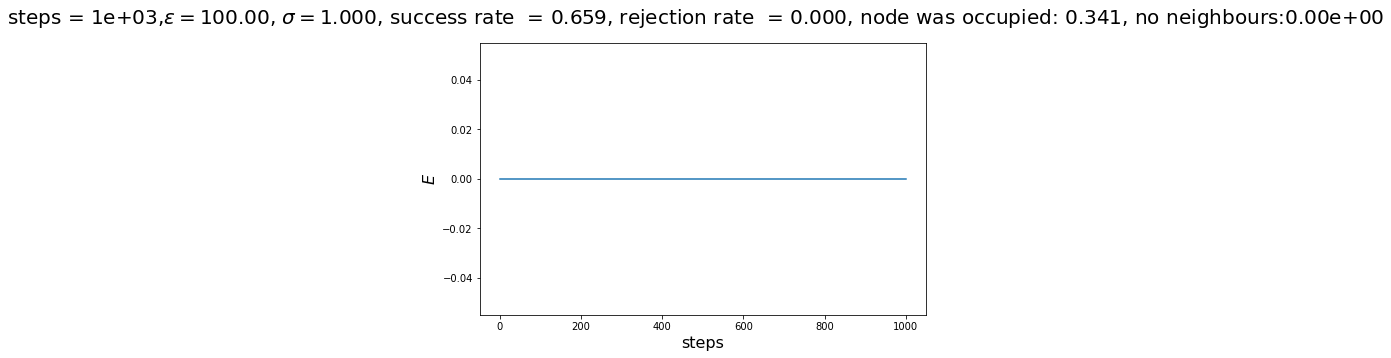

In [39]:
# without weights this example will not show anything great 

show_and_save_results(eps, sigma,E_arr, time_arr, Statistics, steps)

In [40]:
print('lowest energy {} was reached at time step №{} with such sensor placement: {}'.format(E_min, best_step, best_sensor_loc))

lowest energy 0.0 was reached at time step №0 with such sensor placement: [0 1]
